In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import joblib
import json
import pandas as pd
import copy
import hashlib

import src.util as util

# 1. Load Config File

In [6]:
params = util.load_config()
params

{'raw_dataset_dir': 'data/raw/',
 'train_set_path': ['data/processed/X_train.pkl',
  'data/processed/y_train.pkl'],
 'valid_set_path': ['data/processed/X_valid.pkl',
  'data/processed/y_valid.pkl'],
 'test_set_path': ['data/processed/X_test.pkl', 'data/processed/y_test.pkl'],
 'train_feng_set_path': ['data/processed/X_train_feng.pkl',
  'data/processed/y_train_feng.pkl'],
 'valid_feng_set_path': ['data/processed/X_valid_feng.pkl',
  'data/processed/y_valid_feng.pkl'],
 'test_feng_set_path': ['data/processed/X_test_feng.pkl',
  'data/processed/y_test_feng.pkl'],
 'raw_dataset_path': 'data/processed/raw_dataset.pkl',
 'cleaned_raw_dataset_path': 'data/processed/cleaned_raw_dataset.pkl',
 'production_model_path': 'models/production_model.pkl',
 'ohe_stasiun_path': 'models/ohe_stasiun.pkl',
 'le_encoder_path': 'models/le_encoder.pkl',
 'training_log_path': 'log/training_log.json',
 'print_debug': True,
 'datetime_columns': ['tanggal'],
 'int64_columns': ['pm10', 'pm25', 'so2', 'co', 'o3', 

# 2. Load Dataset

In [7]:
def load_train_feng(params: dict) -> pd.DataFrame:
    X_train = util.pickle_load(params["train_feng_set_path"][0])
    y_train = util.pickle_load(params["train_feng_set_path"][1])

    return X_train, y_train

def load_valid_feng(params: dict) -> pd.DataFrame:
    X_valid = util.pickle_load(params["valid_feng_set_path"][0])
    y_valid = util.pickle_load(params["valid_feng_set_path"][1])

    return X_valid, y_valid

def load_test_feng(params: dict) -> pd.DataFrame:
    X_test = util.pickle_load(params["test_feng_set_path"][0])
    y_test = util.pickle_load(params["test_feng_set_path"][1])

    return X_test, y_test

In [14]:
def load_dataset(params: dict) -> pd.DataFrame:
    # Debug message
    util.print_debug("Loading Dataset.")

    # Load data set
    X_train, y_train = load_train_feng(params)
    X_valid, y_valid = load_valid_feng(params)
    X_test, y_test = load_test_feng(params)

    # Debug message
    util.print_debug("Dataset loaded.")

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 3. Create training log template

In [9]:
def training_log_template() -> dict:
    util.print_debug("Creating training log template.")

    # Template
    logger = {
        "model_name": [],
        "model_uid": [],
        "training_time": [],
        "training_date": [],
        "performance": [],
        "f1_score_avg": [],
        "data_configurations": []
    }

    util.print_debug("Training log template created.")

    return logger

In [10]:
def training_log_updater(current_log: dict, params: dict) -> list:
    current_log = copy.deepcopy(current_log)

    # Path for training log file
    log_path = params["training_log_path"]

    # Try to load training log file
    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()

    # If file not found, create a new one
    except FileNotFoundError as fe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()

        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()

    # Add current log to previous log
    last_log.append(current_log)

    # Save updated log
    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    return last_log

# 4. Training and Evaluation

## 4.1. Create Model Object

In [11]:
def create_model_object(params: dict) -> list:
    util.print_debug("Creating model objects.")

    # Create model objects
    lgr = LogisticRegression()
    dct = DecisionTreeClassifier()
    rfc = RandomForestClassifier()
    knn = KNeighborsClassifier()
    xgb = XGBClassifier()

    # Create model lists
    list_of_model = [
        {"model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        {"model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        {"model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        {"model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        {"model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""}
    ]

    util.print_debug("Model objects created.")

    return list_of_model

## 4.2. Training Baseline Model

In [15]:
def train_eval(configuration_model: str, params: dict, hyperparams_model: list = None):
    # Load dataset
    X_train, y_train, \
        X_valid, y_valid, \
        X_test, y_test = load_dataset(params)
    
    # Variable to store trained models
    list_of_trained_model = dict()

    # Create log template
    training_log = training_log_template()

    # Training for every data configuration
    for config_data in X_train:
        # Debug message
        util.print_debug("Training model based on configuration data: {}".format(config_data))

        # Create model objects
        if hyperparams_model == None:
            list_of_model = create_model_object(params)
        else:
            list_of_model = copy.deepcopy(hyperparams_model)

        # Variable to store trained model
        trained_model = list()

        # Load train data based on its configuration
        X_train_data = X_train[config_data]
        y_train_data = y_train[config_data]

        # Train each model by current dataset configuration
        for model in list_of_model:
            # Debug message
            util.print_debug("    Training model: {}".format(model["model_name"]))

            # Training
            training_time = util.time_stamp()
            model["model_object"].fit(X_train_data, y_train_data)
            training_time = (util.time_stamp() - training_time).total_seconds()

            # Debug message
            util.print_debug("    Evaluating model: {}".format(model["model_name"]))

            # Evaluation
            y_predict = model["model_object"].predict(X_valid)
            performance = classification_report(y_valid, y_predict, output_dict=True)
            
            # Debug message
            util.print_debug("    Logging: {}".format(model["model_name"]))

            # Create UID
            uid = hashlib.md5(str(training_time).encode()).hexdigest()

            # Assign model's UID
            model["model_uid"] = uid

            # Create training log data
            training_log["model_name"].append("{}-{}".format(configuration_model, model["model_name"]))
            training_log["model_uid"].append(uid)
            training_log["training_time"].append(training_time)
            training_log["training_date"].append(util.time_stamp())
            training_log["performance"].append(performance)
            training_log["f1_score_avg"].append(performance["macro avg"]["f1-score"])
            training_log["data_configurations"].append(config_data)

            # Collect current trained model
            trained_model.append(copy.deepcopy(model))

            # Debug message
            util.print_debug("      Model {} has been trained for configuration data {}.".format(model["model_name"], config_data))

        # Collect current trained list of model
        list_of_trained_model[config_data] = copy.deepcopy(trained_model)

    # Debug message
    util.print_debug("All combination models and config. data has been trained.")

    return list_of_trained_model, training_log

In [16]:
list_of_trained_model, training_log = train_eval("Baseline", params)

2023-04-06 06:48:18.877361 Loading Dataset.
2023-04-06 06:48:18.910668 Dataset loaded.
2023-04-06 06:48:18.910709 Creating training log template.
2023-04-06 06:48:18.910722 Training log template created.
2023-04-06 06:48:18.910733 Training model based on configuration data: Undersampling
2023-04-06 06:48:18.910743 Creating model objects.
2023-04-06 06:48:18.910869 Model objects created.
2023-04-06 06:48:18.910884     Training model: LogisticRegression
2023-04-06 06:48:18.959705     Evaluating model: LogisticRegression
2023-04-06 06:48:18.974887     Logging: LogisticRegression
2023-04-06 06:48:18.975488       Model LogisticRegression has been trained for configuration data Undersampling.
2023-04-06 06:48:18.975587     Training model: DecisionTreeClassifier
2023-04-06 06:48:18.981468     Evaluating model: DecisionTreeClassifier
2023-04-06 06:48:19.001368     Logging: DecisionTreeClassifier
2023-04-06 06:48:19.002401       Model DecisionTreeClassifier has been trained for configuration da

/home/cahyapacmann/Documents/belajar/ml_process_examples/venv_ml_process/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2023-04-06 06:48:19.450923     Evaluating model: RandomForestClassifier
2023-04-06 06:48:19.492446     Logging: RandomForestClassifier
2023-04-06 06:48:19.515442       Model RandomForestClassifier has been trained for configuration data Undersampling.
2023-04-06 06:48:19.515699     Training model: KNeighborsClassifier
2023-04-06 06:48:19.525327     Evaluating model: KNeighborsClassifier
2023-04-06 06:48:19.572400     Logging: KNeighborsClassifier
2023-04-06 06:48:19.572880       Model KNeighborsClassifier has been trained for configuration data Undersampling.
2023-04-06 06:48:19.572921     Training model: XGBClassifier
2023-04-06 06:48:20.513727     Evaluating model: XGBClassifier
2023-04-06 06:48:20.563649     Logging: XGBClassifier
2023-04-06 06:48:20.578232       Model XGBClassifier has been trained for configuration data Undersampling.
2023-04-06 06:48:20.621222 Training model based on configuration data: Oversampling
2023-04-06 06:48:20.621265 Creating model objects.
2023-04-06 06

/home/cahyapacmann/Documents/belajar/ml_process_examples/venv_ml_process/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2023-04-06 06:48:20.750834     Evaluating model: LogisticRegression
2023-04-06 06:48:20.780303     Logging: LogisticRegression
2023-04-06 06:48:20.780983       Model LogisticRegression has been trained for configuration data Oversampling.
2023-04-06 06:48:20.781047     Training model: DecisionTreeClassifier
2023-04-06 06:48:20.787258     Evaluating model: DecisionTreeClassifier
2023-04-06 06:48:20.806371     Logging: DecisionTreeClassifier
2023-04-06 06:48:20.806664       Model DecisionTreeClassifier has been trained for configuration data Oversampling.
2023-04-06 06:48:20.806691     Training model: RandomForestClassifier
2023-04-06 06:48:21.488592     Evaluating model: RandomForestClassifier
2023-04-06 06:48:21.534564     Logging: RandomForestClassifier
2023-04-06 06:48:21.554927       Model RandomForestClassifier has been trained for configuration data Oversampling.
2023-04-06 06:48:21.555119     Training model: KNeighborsClassifier
2023-04-06 06:48:21.563369     Evaluating model: KN

/home/cahyapacmann/Documents/belajar/ml_process_examples/venv_ml_process/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2023-04-06 06:48:22.444439     Evaluating model: LogisticRegression
2023-04-06 06:48:22.540159     Logging: LogisticRegression
2023-04-06 06:48:22.540509       Model LogisticRegression has been trained for configuration data SMOTE.
2023-04-06 06:48:22.540552     Training model: DecisionTreeClassifier
2023-04-06 06:48:22.553612     Evaluating model: DecisionTreeClassifier
2023-04-06 06:48:22.596863     Logging: DecisionTreeClassifier
2023-04-06 06:48:22.597194       Model DecisionTreeClassifier has been trained for configuration data SMOTE.
2023-04-06 06:48:22.597281     Training model: RandomForestClassifier
2023-04-06 06:48:23.264451     Evaluating model: RandomForestClassifier
2023-04-06 06:48:23.377957     Logging: RandomForestClassifier
2023-04-06 06:48:23.402719       Model RandomForestClassifier has been trained for configuration data SMOTE.
2023-04-06 06:48:23.402765     Training model: KNeighborsClassifier
2023-04-06 06:48:23.416504     Evaluating model: KNeighborsClassifier
20

## 4.3. Choose Best Performance Baseline Model

In [17]:
def get_production_model(list_of_model, training_log, params):
    list_of_model = copy.deepcopy(list_of_model)

    # Debug message
    util.print_debug("Choosing model by metrics score")

    # Create required predefined variable
    curr_production_model = None
    prev_production_model = None
    production_model_log = None

    # Debug message
    util.print_debug("Converting training log type of data from dict to dataframe")

    # Convert diction to pandas
    training_log = pd.DataFrame(copy.deepcopy(training_log))

    # Debug message
    util.print_debug("Trying to load previous production model.")

    # Check if there is a previous production model
    try:
        prev_production_model = util.pickle_load(params["production_model_path"])
        util.print_debug("Previous production model loaded.")
    
    except FileNotFoundError as fe:
        util.print_debug("No previous production model detected, choosing best model only from current trained model.")

    # If previous production model detected:
    if prev_production_model != None:
        # Debug message
        util.print_debug("loading validation data")
        X_valid, y_valid = load_valid_feng(params)

        # Debug message
        util.print_debug("Checking compatibility previous production model's input with current train data's features")

        # Check list features of previous prod. model and curr. dataset
        production_model_features = set(prev_production_model["model_data"]["model_object"].feature_names_in_)
        current_dataset_features = set(X_valid.columns)
        number_of_different_features = len((production_model_features-current_dataset_features) | (current_dataset_features-production_model_features))

        # If feature matched
        if number_of_different_features == 0:
            # Debug message
            util.print_debug("Features compatible.")
            util.print_debug("Reassesing prev. model performance using curr. validation data")

            # Re-predict
            y_pred = prev_production_model["model_data"]["model_object"].predict(X_valid)

            # Re-asses pred. res.
            eval_res = classification_report(y_valid, y_pred, output_dict=True)

            # Debug message
            util.print_debug("Assessing complete.")
            util.print_debug("Storing new metrics data to previous model structure.")

            # Update their performance log
            prev_production_model["model_log"]["performance"] = eval_res
            prev_production_model["model_log"]["f1_score_avg"] = eval_res["macro avg"]["f1-score"]

            # Debug message
            util.print_debug("Adding previous model data to curr. training log and list of model")

            # Add prev. prod. model log to curr. log
            training_log = pd.concat([training_log, pd.DataFrame([prev_production_model["model_log"]])])

            # add previous prod. model
            list_of_model["prev_production_model"] = [copy.deepcopy(prev_production_model["model_data"])]

        else:
            # To indicate that we are not using previous production model
            prev_production_model = None

            # Debug message
            util.print_debug("Different featrues between prod. model with curr. dataset is detected, ignoring production dataset")

    # Debug message
    util.print_debug("Sorting training log by f1 macro avg and training time")

    # Sort
    best_model_log = training_log.sort_values(["f1_score_avg", "training_time"], ascending=[False, True]).iloc[0]

    # Debug message
    util.print_debug("Searching model data based on sorted training log")

    # Get model object with greates f1 score macro avg by using UID
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_log["model_uid"]:
                curr_production_model = dict()
                curr_production_model["model_data"] = copy.deepcopy(model_data)
                curr_production_model["model_log"] = copy.deepcopy(best_model_log.to_dict())
                curr_production_model["model_log"]["model_name"] = "Production-{}".format(curr_production_model["model_data"]["model_name"])
                curr_production_model["model_log"]["training_date"] = str(curr_production_model["model_log"]["training_date"])
                production_model_log = training_log_updater(curr_production_model["model_log"], params)
                break

    
    # In case UID not found
    if curr_production_model == None:
        raise RuntimeError("The best model not found in your list of model")
    
    # Debug message
    util.print_debug("Model chosen.")

    # Dump chosen prod. model
    util.pickle_dump(curr_production_model, params["production_model_path"])

    return curr_production_model, production_model_log, training_log


In [18]:
model, production_model_log, training_logs = get_production_model(list_of_trained_model, training_log, params)

2023-04-06 07:06:18.057062 Choosing model by metrics score
2023-04-06 07:06:18.057394 Converting training log type of data from dict to dataframe
2023-04-06 07:06:18.073972 Trying to load previous production model.
2023-04-06 07:06:18.074231 No previous production model detected, choosing best model only from current trained model.
2023-04-06 07:06:18.074252 Sorting training log by f1 macro avg and training time
2023-04-06 07:06:18.079974 Searching model data based on sorted training log
2023-04-06 07:06:18.082747 Model chosen.


In [24]:
training_logs

,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,Baseline-LogisticRegression,854ce08c9d813341beb097a1ecbaaeab,0.048790,2023-04-06 06:48:18.975112,"{'0': {'precision': 0.725, 'recall': 0.9666666...",0.902521,Undersampling
1,Baseline-DecisionTreeClassifier,74433e17c3785391dd4f2f575b42c609,0.005822,2023-04-06 06:48:19.001596,"{'0': {'precision': 0.8108108108108109, 'recal...",0.940939,Undersampling
2,Baseline-RandomForestClassifier,6b30452cf065da7feef487727fb4ddd9,0.448286,2023-04-06 06:48:19.492521,"{'0': {'precision': 0.7692307692307693, 'recal...",0.925976,Undersampling
3,Baseline-KNeighborsClassifier,d62ae43b0677e330d2cd1c89bffbadea,0.009555,2023-04-06 06:48:19.572497,"{'0': {'precision': 0.6521739130434783, 'recal...",0.878864,Undersampling
4,Baseline-XGBClassifier,4bfa274a7de518469757bcea6bd55cd3,0.940780,2023-04-06 06:48:20.563718,"{'0': {'precision': 0.75, 'recall': 1.0, 'f1-s...",0.918768,Undersampling
5,Baseline-LogisticRegression,4e3f7b885c41fc70e89d9e5f428362e5,0.128956,2023-04-06 06:48:20.780481,"{'0': {'precision': 0.7073170731707317, 'recal...",0.895681,Oversampling
6,Baseline-DecisionTreeClassifier,55e014d5182bfb3c54dc1222d706e518,0.006161,2023-04-06 06:48:20.806442,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,Oversampling
7,Baseline-RandomForestClassifier,f0463ebb23f8918a09c810a19ddcb7c6,0.681863,2023-04-06 06:48:21.534628,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,Oversampling
8,Baseline-KNeighborsClassifier,b2cfe37d2949fcde21546d99427e0320,0.008157,2023-04-06 06:48:21.620136,"{'0': {'precision': 0.8055555555555556, 'recal...",0.931612,Oversampling
9,Baseline-XGBClassifier,7822eda59f1ea2657269d2e0e08207a9,0.609187,2023-04-06 06:48:22.258344,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,Oversampling


# 5. Hyperparameter tuning

In [32]:
def create_dist_params(model_name):
    # Define model params
    dist_params_xgb = {
        "n_estimators": [50, 100, 200, 300]
    }
    dist_params_dct = {
        "criterion": ["gini", "entropy", "log_loss"],
        "min_samples_split": [2, 4, 6, 10, 15],
        "min_samples_leaf": [2, 4, 6, 10, 15]
    }
    dist_params_knn = {
        "criterion": ["ball_tree", "kd_tree"],
        "n_neighbors": [2, 3, 4, 5, 6],
        "leaf_size": [2, 3, 4, 5, 6]
    }
    dist_params_lgr = {
        "penalty": ["l1", "l2"],
        "C": [0.01, 0.05, 0.15, 0.20],
        "max_iter": [100, 200, 300, 400]
    }
    dist_params_rfc = {
        "criterion": ["gini", "entropy", "log_loss"],
        "n_estimators": [50, 100, 200]
    }

    # Make all models
    dist_params = {
        "XGBClassifier": dist_params_xgb,
        "DecisionTreeClassifier": dist_params_dct,
        "KNeighborsClassifier": dist_params_knn,
        "LogisticRegression": dist_params_lgr,
        "RandomForestClassifier": dist_params_rfc
    }

    return dist_params[model_name]

In [33]:
def hyper_params_tuning(model):
    # Create a deepcopy
    model = copy.deepcopy(model)

    # create model's params
    dist_params = create_dist_params(model["model_data"]["model_name"])

    # Create model obj
    model_rsc = RandomizedSearchCV(model["model_data"]["model_object"], dist_params, n_jobs=-1)
    model_data = {
        "model_name": model["model_data"]["model_name"],
        "model_object": model_rsc,
        "model_uid": ""
    }

    return [model_data]

In [34]:
list_of_trained_model, training_log = train_eval("Hyperparams_Tuning", params, hyper_params_tuning(model))

2023-04-06 07:18:10.345372 Loading Dataset.
2023-04-06 07:18:10.362316 Dataset loaded.
2023-04-06 07:18:10.362472 Creating training log template.
2023-04-06 07:18:10.362527 Training log template created.
2023-04-06 07:18:10.362575 Training model based on configuration data: Undersampling
2023-04-06 07:18:10.363367     Training model: DecisionTreeClassifier
2023-04-06 07:18:10.996408     Evaluating model: DecisionTreeClassifier
2023-04-06 07:18:11.031725     Logging: DecisionTreeClassifier
2023-04-06 07:18:11.032965       Model DecisionTreeClassifier has been trained for configuration data Undersampling.
2023-04-06 07:18:11.034199 Training model based on configuration data: Oversampling
2023-04-06 07:18:11.035056     Training model: DecisionTreeClassifier
2023-04-06 07:18:11.990433     Evaluating model: DecisionTreeClassifier
2023-04-06 07:18:12.042072     Logging: DecisionTreeClassifier
2023-04-06 07:18:12.043080       Model DecisionTreeClassifier has been trained for configuration dat

In [36]:
model, production_model_log, training_logs = get_production_model(list_of_trained_model, training_log, params)

2023-04-06 07:19:10.300593 Choosing model by metrics score
2023-04-06 07:19:10.300679 Converting training log type of data from dict to dataframe
2023-04-06 07:19:10.302143 Trying to load previous production model.
2023-04-06 07:19:10.304017 Previous production model loaded.
2023-04-06 07:19:10.304075 loading validation data
2023-04-06 07:19:10.307454 Checking compatibility previous production model's input with current train data's features
2023-04-06 07:19:10.307517 Features compatible.
2023-04-06 07:19:10.307532 Reassesing prev. model performance using curr. validation data
2023-04-06 07:19:10.326010 Assessing complete.
2023-04-06 07:19:10.326056 Storing new metrics data to previous model structure.
2023-04-06 07:19:10.326074 Adding previous model data to curr. training log and list of model
2023-04-06 07:19:10.336524 Sorting training log by f1 macro avg and training time
2023-04-06 07:19:10.341084 Searching model data based on sorted training log
2023-04-06 07:19:10.342331 Model ch

In [37]:
training_logs

,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,Hyperparams_Tuning-DecisionTreeClassifier,7f3642b9045a1b79b9f5c8d653d8d286,0.632740,2023-04-06 07:18:11.031810,"{'0': {'precision': 0.75, 'recall': 1.0, 'f1-s...",0.918768,Undersampling
1,Hyperparams_Tuning-DecisionTreeClassifier,1842c9eb1b6882e30c27ee3b91279509,0.955278,2023-04-06 07:18:12.042155,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,Oversampling
2,Hyperparams_Tuning-DecisionTreeClassifier,86d74b7e91ee379f547fef1f2aa52588,1.053436,2023-04-06 07:18:13.142566,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,SMOTE
0,Production-DecisionTreeClassifier,55e014d5182bfb3c54dc1222d706e518,0.006161,2023-04-06 06:48:20.806442,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,Oversampling


# 6. Take a look at confusion Matrix

In [35]:
X_valid, y_valid = load_valid_feng(params)

In [38]:
y_pred = model["model_data"]["model_object"].predict(X_valid)

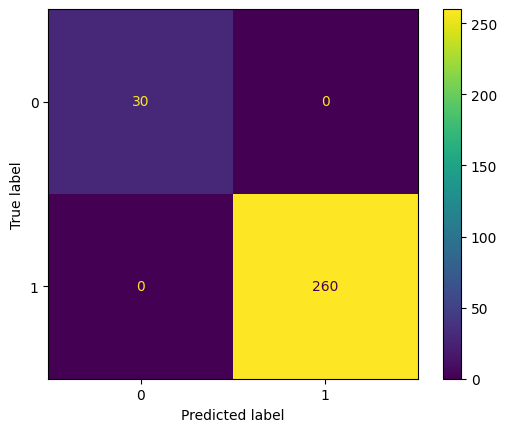

In [39]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)